In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
#import statsmodels.api as sm
from statsmodels.stats import multitest
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from cycler import cycler
import os
import itertools
import ratmetab
if os.getlogin() == 'jonesa7':
    import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Rationale

Discover metabolic changes between aged impaired (AI) and aged unimpaired (AU) rats.  Also, compare both of these to young (Y) rats.

## Import data

We read and quality filter data sets.  There are four of them:
1. brain
1. blood
1. brain old
1. blood old

There are two quality filters, that, for each data set, remove metabolites...
1. ...with $\le 1$ observed (non-missing) value in any rat group (filter 1)
1. ...with $\le 80 \%$ observed (non-missing) values (filter 2)

The result is data frames of metabolite levels, whose rows are samples (one from each rat), and whose columns are metabolite code names.  These code names are converted into scientific metabolite names using `Rat_codebook_27_Oct_2022.csv`

In [2]:
if os.getlogin() == 'jonesa7':
    codebookpath = '../../resources/rat-metabolites/Rat_codebook_27_Oct_2022.csv'
    datapath = {
        'blood': 'blood_27_Oct_2022',
        'brain': 'brain_27_Oct_2022',
        'blood old': 'old_blood_17_Nov_2022',
        'brain old': 'old_brain_17_Nov_2022',
               }
    data = {k: ratmetab.read_data('../../resources/rat-metabolites/Rat_' + v + '.csv', codebookpath, liberal_filter=True) for k, v in datapath.items()}
    excluded_metabolites = {k: ratmetab.read_data('../../resources/rat-metabolites/Rat_' + v + '.csv', codebookpath, liberal_filter=True, return_m2exclude=True) for k, v in datapath.items()}
    excluded_metabolites_cons = {k: ratmetab.read_data('../../resources/rat-metabolites/Rat_' + v + '.csv', codebookpath, liberal_filter=False, return_m2exclude=True) for k, v in datapath.items()}
else:
    datapath_blood = 'some/path'
    datapath_brain = 'some/path'
    codebookpath = 'some/path'

data['brain'].head()

,LIScore,Group,Cholic acid,Taurocholic acid,Taurochenodeoxycholic acid,Tauromuricholic acid (alpha + beta),Carnitine,Acetylcarnitine,Propionylcarnitine,Malonylcarnitine (Hydroxybutyrylcarnitine),...,Phosphatidylethanolamine ae 40:2,Phosphatidylethanolamine ae 42:2,Phosphatidylglycerol aa 32:0,Phosphatidylglycerol aa 34:1,Phosphatidylglycerol aa 36:2,Phosphatidylglycerol aa 36:4,Phosphatidylglycerol aa 38:5,Phosphatidylserine aa 34:1,Phosphatidylserine aa 36:1,Phosphatidylserine aa 40:6
idno,,,,,,,,,,,,,,,,,,,,,
105,249,AI,NaN,NaN,NaN,NaN,11.034,1.521,NaN,NaN,...,1.146,1.350,0.3983,4.147,0.6962,2.943,0.6260,3.963,23.820,95.495
1158,201,AU,NaN,0.327,0.03300,0.2796,10.904,4.107,0.142000,NaN,...,NaN,1.143,0.3517,3.036,0.5238,2.593,0.5484,4.052,NaN,76.815
1172,155,AU,NaN,0.378,0.01784,0.2104,10.132,4.187,0.072465,0.060798,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1174,194,AU,NaN,0.146,NaN,0.0652,10.024,4.249,0.146000,NaN,...,1.071,1.153,0.3748,3.530,0.5092,2.393,0.5173,3.979,34.066,65.968
127,291,AI,NaN,NaN,NaN,NaN,11.611,3.001,NaN,0.077633,...,1.170,1.413,0.4821,4.428,0.6463,2.665,0.5714,4.618,39.461,93.804


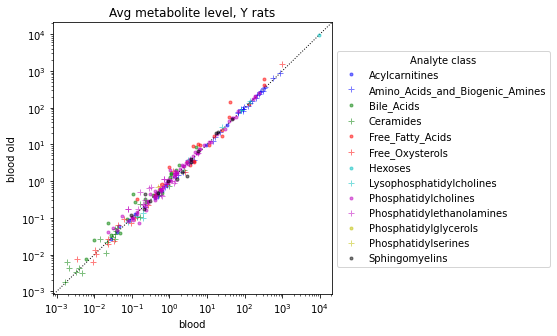

In [3]:
def take1avg(metabolite, group, dataset, data=data):
    df = data[dataset]
    res = df.loc[df.Group == group, metabolite].mean()
    return(res)

def take_all_avgs(group, dataset, data=data):
    l = [take1avg(metabolite, group, dataset, data=data) for metabolite in data[dataset].columns[2:]]
    s = pd.Series(l, index=data[dataset].columns[2:])
    return(s)

def avg_metab_scatter(group, datasetA, datasetB, data=data):
    l = [take_all_avgs(group, dataset, data=data) for dataset in [datasetA, datasetB]]
    df = pd.concat(l, axis=1, join='inner')
    df.columns = [datasetA, datasetB]
    return(df)

def avg_metab_scatter_plot(group, datasetA, datasetB, data=data, codebookpath=codebookpath):
    codebook = pd.read_csv(codebookpath, index_col='MetaboliteName')
    df = avg_metab_scatter(group, datasetA, datasetB, data=data)
    df = pd.concat([df, codebook.AnalyteClass], axis=1)
    fig, ax = plt.subplots(figsize=(5, 5))
    my_cycler = (cycler(color=list('bgrcmyk')) * cycler(marker=['.', '+']))
    ax.set_prop_cycle(my_cycler)
    ax.set_xlabel(datasetA)
    ax.set_ylabel(datasetB)
    ax.set_title('Avg metabolite level, ' + group + ' rats')
    ax.axline((0, 0), slope=1, linewidth=1, linestyle='dotted', color='black')
    for aclass in np.unique(df.AnalyteClass):
        clsdata = df.loc[df.AnalyteClass == aclass]
        ax.plot(clsdata[datasetA], clsdata[datasetB], label=aclass, alpha=0.5, linestyle = '')
        #ax.scatter(x=datasetA, y=datasetB, data=clsdata, label=aclass)
    ax.set_xscale('log')
    ax.set_yscale('log')
    fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5), title='Analyte class')
    return((fig, ax))


fig, ax = avg_metab_scatter_plot('Y', 'blood', 'blood old')

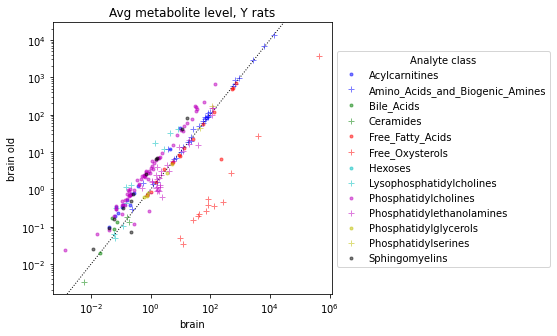

In [4]:
fig, ax = avg_metab_scatter_plot('Y', 'brain', 'brain old')
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'avg-metab-brain-vs-brain-old-Y')

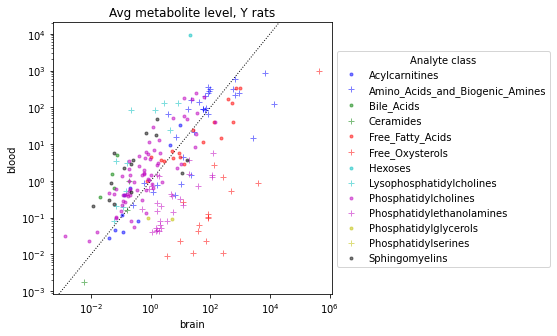

In [5]:
fig, ax = avg_metab_scatter_plot('Y', 'brain', 'blood')

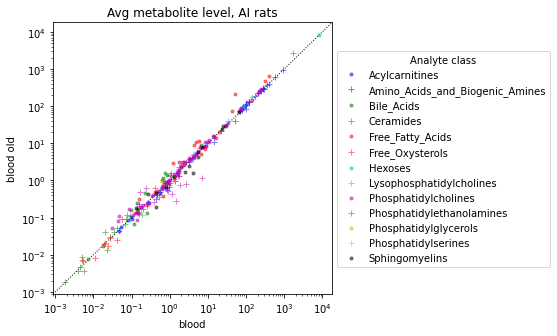

In [6]:
fig, ax = avg_metab_scatter_plot('AI', 'blood', 'blood old')

## Statistical comparison of AI, AU, Y groups

We apply the two sample t-test for each null hypotheses of no change in a given methabolite's level in condition A relative to that in condition B.  Before we write the complete set of resuls into `summary.csv`, we perform FDR control at various $\alpha$s using the Benjamini-Hochberg procedure.  The bonferroni corrected $\alpha$ values are also calculated.

In [7]:
def extract2groups(metabolite, groupA='AU', groupB='AI', df=data['blood']):
    l = [df.loc[df.Group == g, metabolite].dropna() for g in [groupA, groupB]]
    return(l)

def get_log_p(A, B):
    val = - np.log10(stats.ttest_ind(A, B)[1])
    return(val)

def get_effect_size(A, B):
    '''
    The effect size x is B relative to A, so if A > B => x < 0
    '''
    #val = B.mean() - A.mean() # the original definition; does not normalize effect size!
    OR = B.mean() / A.mean()
    log2OR = np.log2(OR)
    return(log2OR)

def get_both(metabolite, groupA='AU', groupB='AI', df=data['blood']):
    A, B = extract2groups(metabolite, groupA, groupB, df)
    log_p = get_log_p(A, B)
    fx_size = get_effect_size(A, B)
    return((fx_size, log_p))

def get_both_all(groupA='AU', groupB='AI', df=data['blood']):
     metabolites = df.columns[2:]
     l = [get_both(m, groupA, groupB, df) for m in metabolites]
     fx_sizes = [x[0] for x in l]
     log_ps = [x[1] for x in l]
     return((fx_sizes, log_ps))

In [8]:
comparisons = {
    'AI vs. AU': ['AU', 'AI'],
    'AI vs. Y': ['Y', 'AI'],
    'AU vs. Y': ['Y', 'AU'],
              }
results = {d: {k: get_both_all(*v, df=data[d]) for k, v in comparisons.items()} for d in data.keys()}

In [9]:
def writeResults(dataset='brain', comparison='AI vs. AU', alpha=0.05, method='fdr_bh', data=data, results=results):
    dat = data[dataset]
    codebook = pd.read_csv(codebookpath, index_col='MetaboliteName')
    metabolites = dat.columns[2:]
    metab_class = codebook.loc[metabolites, 'AnalyteClass']
    res = results[dataset]
    t = res[comparison]
    direction = ['Increase' if x>0 else 'Decrease' for x in t[0]]
    pvals = 10 ** (-np.array(t[1]))
    reject, pvals_corrected, alphacSidak, alphacBonf = multitest.multipletests(pvals, alpha=alpha, method=method)
    df = pd.DataFrame({'Dataset':dataset, 'Comparison': comparison,
                       'Analyte class': metab_class, 'Metabolite': metabolites,
                       'Effect size':t[0],'"- log p"':t[1], 'p': pvals,
                       r'Corrected p': pvals_corrected,
                       r'Reject H0': reject,
                       r'Bonferroni alpha': alphacBonf,
                       'Direction of change': direction})
    df = df.sort_values('Effect size')
    df = df.sort_values('p')
    df['Rank'] = np.arange(len(df)) + 1
    return(df)

In [10]:
def get_summary(data, results, liberal_only=False):
    def helper(df, dataset, liberal_only=liberal_only):
        if not liberal_only:
            return(df)
        rows = set(excluded_metabolites_cons[dataset]).difference(set(excluded_metabolites[dataset]))
        return(df.loc[rows])
    ll = [[helper(writeResults(dataset=d, comparison=c), d, liberal_only) for c in comparisons.keys()] for d in data.keys()]
    #ll = [[writeResults(dataset=d, comparison=c) for c in comparisons.keys()] for d in data.keys()]
    l = itertools.chain(*ll)
    summary = pd.concat(l)
    return(summary)

summary = get_summary(data=data, results=results)
summary_lib_only = get_summary(data=data, results=results, liberal_only=True)

if os.getlogin() == 'jonesa7':
    summary.to_csv('../../results/2022-11-09-rat-metabolites/summary.csv')
summary

,Dataset,Comparison,Analyte class,Metabolite,Effect size,"""- log p""",p,Corrected p,Reject H0,Bonferroni alpha,Direction of change,Rank
Phosphatidylcholine aa C40:5,blood,AI vs. AU,Phosphatidylcholines,Phosphatidylcholine aa C40:5,-0.656900,1.831301,0.014747,0.769241,False,0.000174,Decrease,1
Linolenic acid,blood,AI vs. AU,Free_Fatty_Acids,Linolenic acid,-0.442021,1.707973,0.019590,0.769241,False,0.000174,Decrease,2
"5-beta,6-beta-Epoxycholesterol",blood,AI vs. AU,Free_Oxysterols,"5-beta,6-beta-Epoxycholesterol",-1.162864,1.677275,0.021024,0.769241,False,0.000174,Decrease,3
Spermine,blood,AI vs. AU,Amino_Acids_and_Biogenic_Amines,Spermine,0.550324,1.646695,0.022558,0.769241,False,0.000174,Increase,4
trans-4-Hydroxyproline,blood,AI vs. AU,Amino_Acids_and_Biogenic_Amines,trans-4-Hydroxyproline,0.969954,1.588279,0.025806,0.769241,False,0.000174,Increase,5
...,...,...,...,...,...,...,...,...,...,...,...,...
Phosphatidylcholine aa C36:4,brain old,AU vs. Y,Phosphatidylcholines,Phosphatidylcholine aa C36:4,-0.003863,0.018364,0.958596,0.975714,False,0.000219,Decrease,224
Sphingomyelin C18:0,brain old,AU vs. Y,Sphingomyelins,Sphingomyelin C18:0,0.005093,0.013230,0.969996,0.981908,False,0.000219,Increase,225
Phosphatidylethanolamine aa 34:1,brain old,AU vs. Y,Phosphatidylethanolamines,Phosphatidylethanolamine aa 34:1,0.003257,0.011755,0.973295,0.981908,False,0.000219,Increase,226
Phosphatidylethanolamine ae 40:2,brain old,AU vs. Y,Phosphatidylethanolamines,Phosphatidylethanolamine ae 40:2,-0.002478,0.008930,0.979647,0.983963,False,0.000219,Decrease,227


## Volcano plots

These plots show that AU and AI are more similar to each other than either of them to Y.  Another finding is that metabolites in the same predefined metabolite group are clustered together, which confirms biological signals in the possibly qiute noisy data.

In [11]:
def volcano_subplot(axi, df, comparison, dataset, classes, dolabel=False):
    my_cycler = (cycler(color=list('bgrcmyk')) * cycler(marker=['.', '+']))
    axi.set_prop_cycle(my_cycler)
    bonf_alpha = -np.log10(df['Bonferroni alpha'].to_list()[0])
    axi.axhline(y=bonf_alpha, linestyle='dotted', color='black', linewidth=1)
    for k, cls in enumerate(classes):
        clsdf = df.loc[(df['Analyte class'] == cls) & (df.Dataset == dataset)]
        label = cls if dolabel else None
        axi.plot(clsdf['Effect size'], clsdf['"- log p"'], label=label, alpha=0.5, linestyle = '')
        #axi.scatter(x=clsdf['Effect size'], y=clsdf['"- log p"'], label=cls, alpha=0.5) # this does not work with cycler & marker 
        axi.set_title(comparison, fontsize=14)
        axi.set_ylabel(dataset, fontsize=14)
    return(axi)

def my_volcano(summary, swapij=False, figsize=(15, 20)):
    comparisons = np.unique(summary.Comparison)
    datasets = np.unique(summary.Dataset)
    classes = np.unique(summary['Analyte class'])
    fig, ax = plt.subplots(len(datasets), len(comparisons), figsize=figsize, sharey=True, sharex=True, squeeze=False)
    for i, dataset in enumerate(datasets):
        for j, comparison in enumerate(comparisons):
            df = summary.loc[(summary.Dataset == dataset) & (summary.Comparison == comparison)]
            axi = ax[j, i] if swapij else ax[i, j]
            dolabel = (i == 0) and (j == 0)
            volcano_subplot(axi, df, comparison, dataset, classes, dolabel=dolabel)
    fig.supxlabel(r'$\log_{2}$ fold change', fontsize=16)
    fig.supylabel(r'$- \log_{10} p$', fontsize=16)
    fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5), title='Analyte class')
    return((fig, ax))

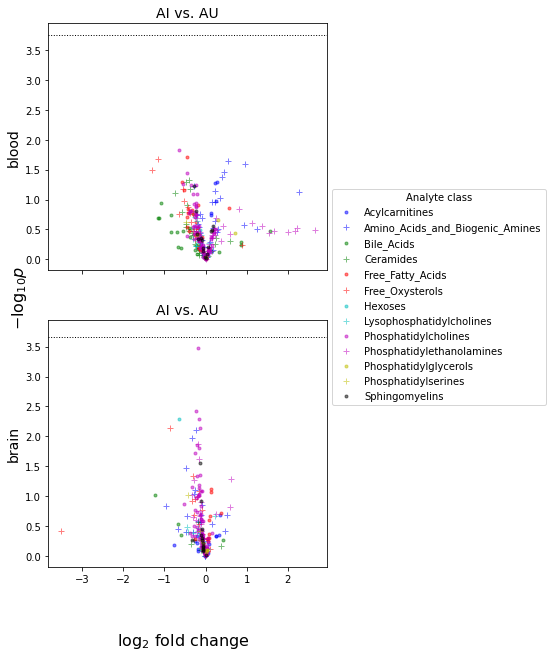

In [12]:
fig, ax = my_volcano(summary.loc[(summary.Comparison == 'AI vs. AU') & summary.Dataset.isin(['blood', 'brain'])], figsize=(5, 10))
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'volcano-plots-aged-newdata')

Below only those metabolites are plotted that we gained by replacing the more conservative filter 2 with the more liberal filter 1.

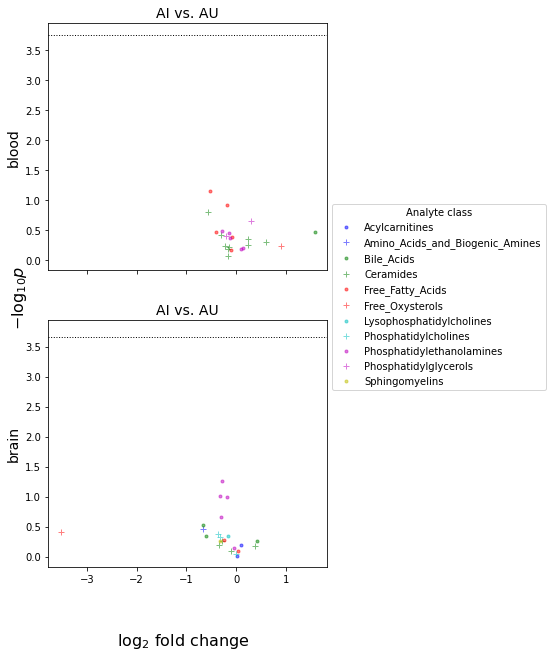

In [13]:
fig, ax = my_volcano(summary_lib_only.loc[(summary_lib_only.Comparison == 'AI vs. AU') & summary_lib_only.Dataset.isin(['blood', 'brain'])], figsize=(5, 10))
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'volcano-plots-aged-newdata_lib_only')

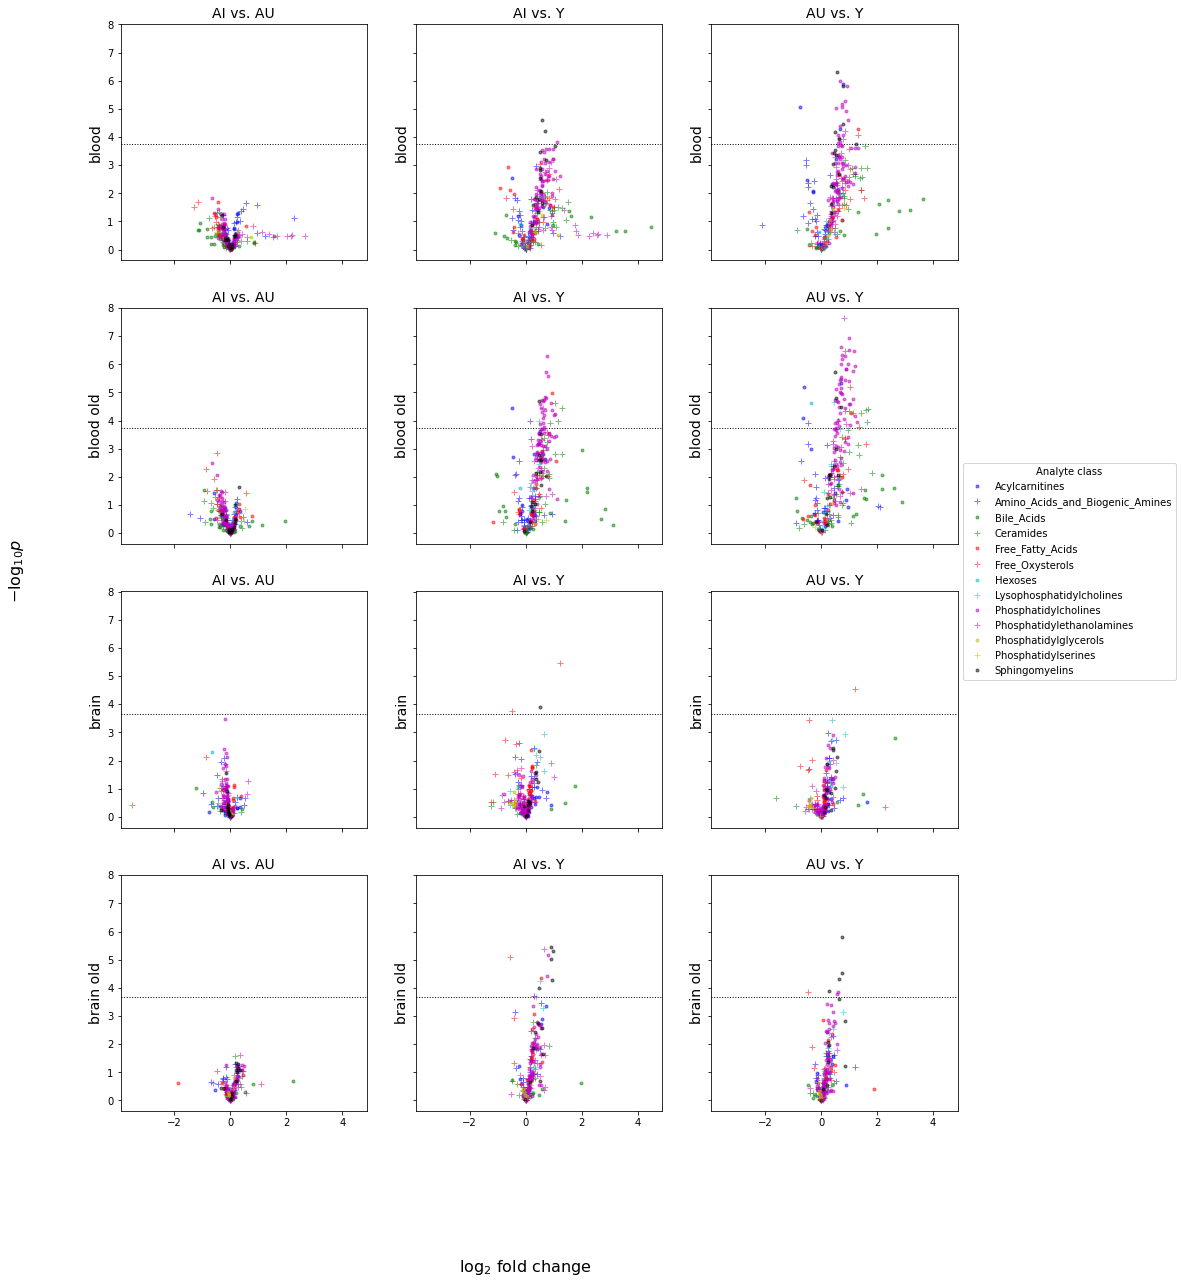

In [14]:
fig, ax = my_volcano(summary)
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'volcano-plots')

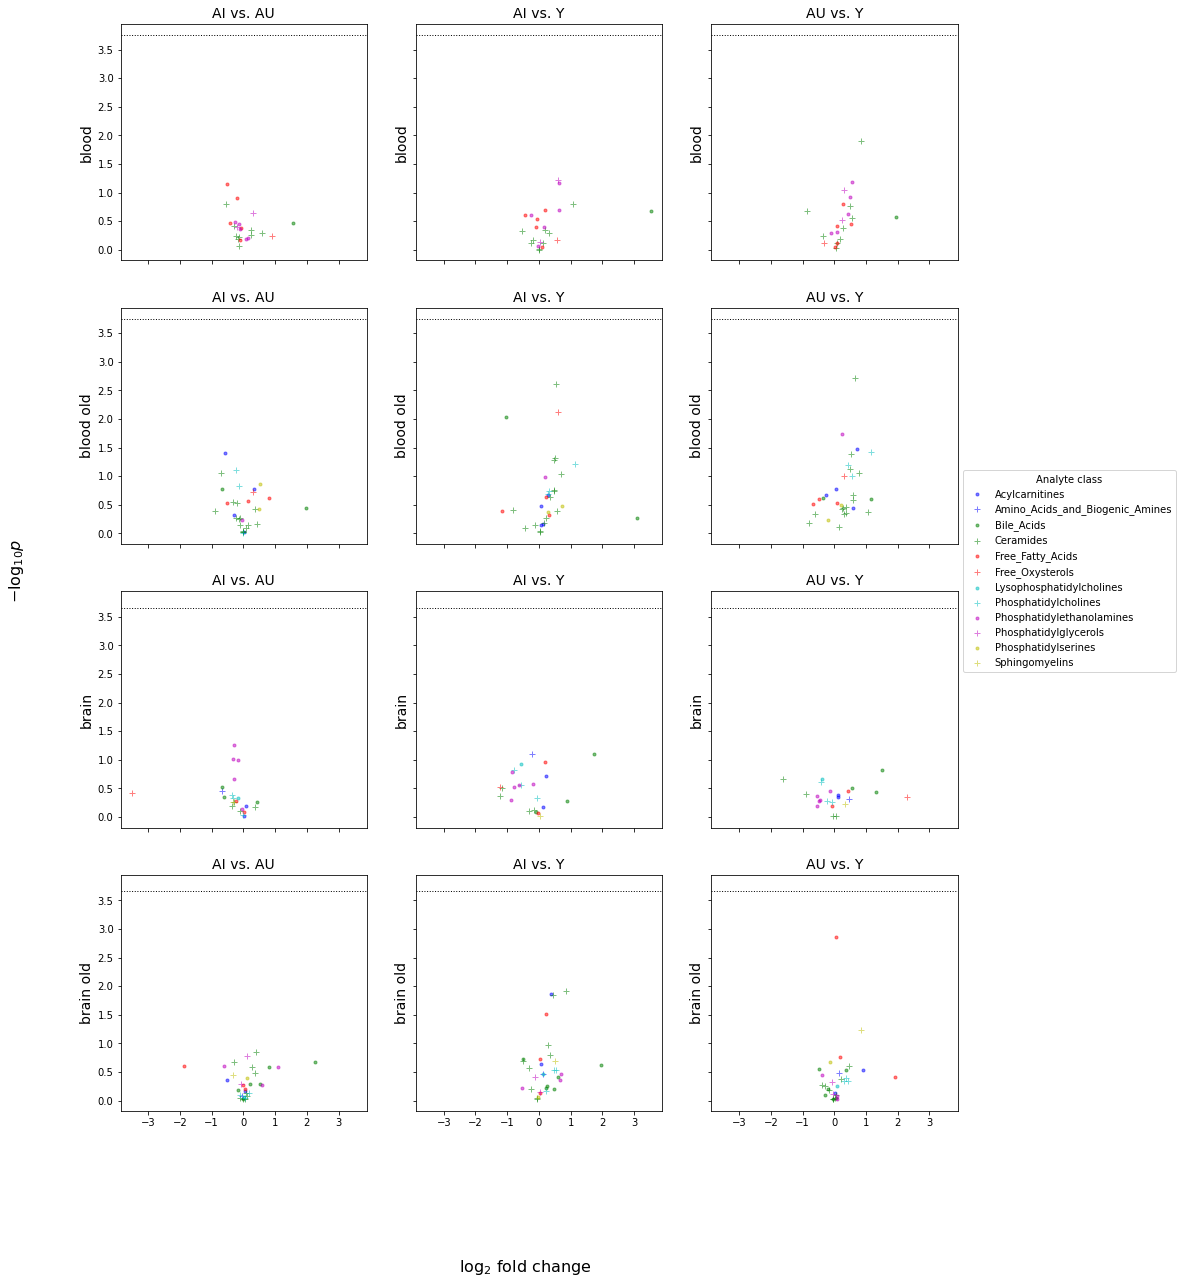

In [15]:
fig, ax = my_volcano(summary_lib_only)
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'volcano-plots_lib_only')

## Comparing data sets

These plots investigate how well findings replicate from the old to the present data sets or how metabolic changes differ in blood vs brain.

In [16]:
def dataset_scatter(datasetA, datasetB, comparison, ax, statistic='"- log p"', summary=summary, rank_thrs=20):
    A, B = [summary.loc[(summary.Dataset == d) & (summary.Comparison == comparison), [statistic, 'Rank']] for d in [datasetA, datasetB]]
    df = pd.concat([A, B], axis=1, join='inner')
    df.columns = [datasetA, 'Rank ' + datasetA, datasetB, 'Rank ' + datasetB]
    df['color'] = None
    df.loc[(df['Rank ' + datasetA] <= rank_thrs) & (df['Rank ' + datasetB] <= rank_thrs), 'color'] = 'orange'
    df.loc[(df['Rank ' + datasetA] <= rank_thrs) & (df['Rank ' + datasetB] > rank_thrs), 'color'] = 'magenta'
    df.loc[(df['Rank ' + datasetA] > rank_thrs) & (df['Rank ' + datasetB] <= rank_thrs), 'color'] = 'blue'
    df.loc[(df['Rank ' + datasetA] > rank_thrs) & (df['Rank ' + datasetB] > rank_thrs), 'color'] = 'lightgray'
    #return((thrsA, thrsB))
    ax.scatter(x=datasetA, y=datasetB, data=df, marker='.', color=df.color)
    color = 'black'
    linestyle = 'dotted'
    linewidth = 1
    if statistic == '"- log p"':
        ax.axvline(df.loc[df['Rank ' + datasetA] == rank_thrs, datasetA].to_list()[0], color=color, linestyle=linestyle, linewidth=linewidth)
        ax.axhline(df.loc[df['Rank ' + datasetB] == rank_thrs, datasetB].to_list()[0], color=color, linestyle=linestyle, linewidth=linewidth)
    if statistic == 'Effect size':
        ax.axline((0, 0), slope=1, color=color, linestyle=linestyle, linewidth=linewidth)
    ax.set_xlabel(datasetA)
    ax.set_ylabel(datasetB)
    ax.set_title(statistic + ', ' + comparison)
    return(ax)

def datset_2scatters(datasetA, datasetB, comparison, suptitle=''):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(suptitle)
    for statistic, axi in zip(['"- log p"', 'Effect size'], ax):
        dataset_scatter(datasetA=datasetA, datasetB=datasetB, comparison=comparison, statistic=statistic, ax=axi)
    return((fig, ax))

### Comparing results from new vs old brain data

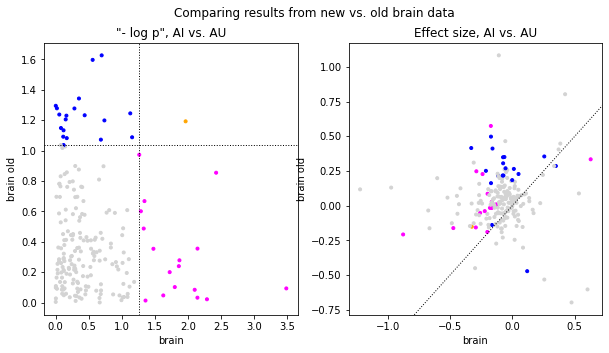

In [17]:
fig, ax = datset_2scatters('brain', 'brain old', comparison='AI vs. AU', suptitle='Comparing results from new vs. old brain data')
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'brain-brain_old-consistency')

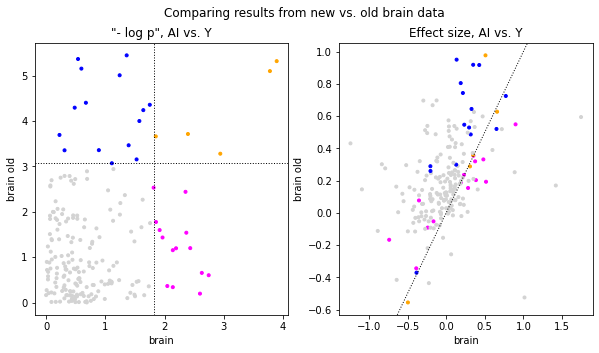

In [18]:
fig, ax = datset_2scatters('brain', 'brain old', comparison='AI vs. Y', suptitle='Comparing results from new vs. old brain data')
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'brain-brain_old-consistency_AIvsY')

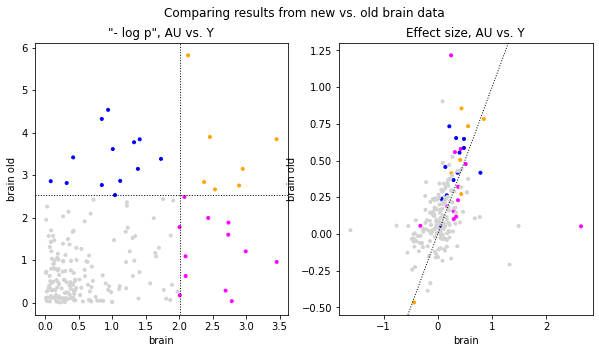

In [19]:
fig, ax = datset_2scatters('brain', 'brain old', comparison='AU vs. Y', suptitle='Comparing results from new vs. old brain data')
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'brain-brain_old-consistency_AUvsY')

### Comparing results from new vs old blood data

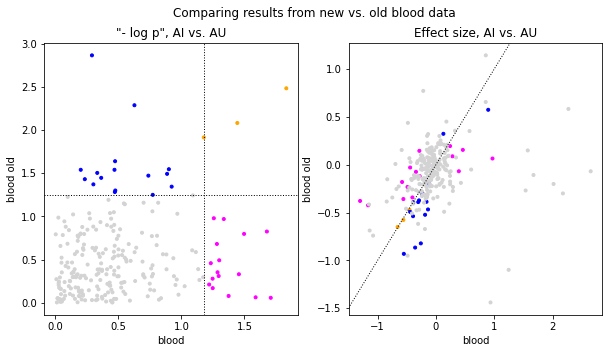

In [20]:
fig, ax = datset_2scatters('blood', 'blood old', comparison='AI vs. AU', suptitle='Comparing results from new vs. old blood data')
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'blood-blood_old-consistency')

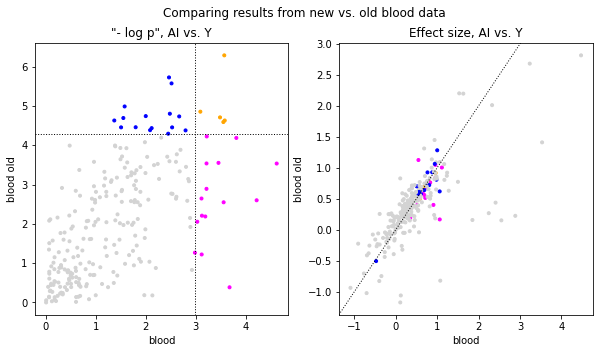

In [21]:
fig, ax = datset_2scatters('blood', 'blood old', comparison='AI vs. Y', suptitle='Comparing results from new vs. old blood data')
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'blood-blood_old-consistency_AIvsY')

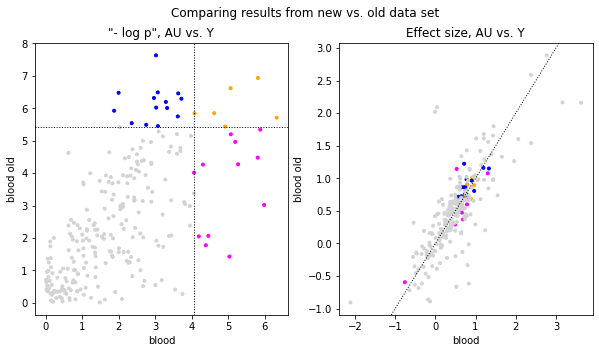

In [22]:
fig, ax = datset_2scatters('blood', 'blood old', comparison='AU vs. Y', suptitle='Comparing results from new vs. old data set')
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'blood-blood_old-consistency-AUvsY')

### Comparing results from brain vs blood

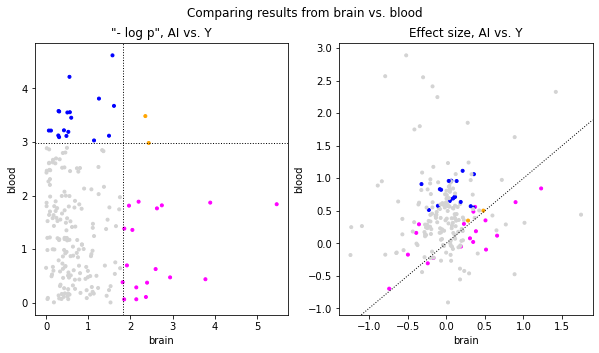

In [23]:
fig, ax = datset_2scatters('brain', 'blood', comparison='AI vs. Y', suptitle='Comparing results from brain vs. blood')
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'blood-brain-consistency-AIvsY')

In [24]:
%connect_info

{
  "shell_port": 63585,
  "iopub_port": 63586,
  "stdin_port": 63587,
  "control_port": 63589,
  "hb_port": 63588,
  "ip": "127.0.0.1",
  "key": "21c451d6-e327a8c56b415d89136b01e8",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-d60db0be-83ff-4c47-8da5-968e5c37eb3d.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
